<a href="https://colab.research.google.com/github/AHMEDPUCO/CMP-4006-4661/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

Leemos información

In [32]:
data = pd.read_csv('nyc_taxi_hw.csv')

In [31]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_duration_minutes,km_recorridos,month,year,hora
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,6,1.029601,6,2009,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,50,8.443441,1,2010,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,8,1.389132,8,2011,00
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,16,2.795790,4,2012,04
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,11,1.998338,3,2010,07


In [30]:
print(data.isna().sum()) #valores faltantes
conteo_pasajeros = data['passenger_count'].value_counts()
print("Conteo de pasajeros:")
print(conteo_pasajeros)

fare_amount              0
pickup_datetime          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
passenger_count          0
trip_duration_minutes    0
km_recorridos            0
month                    0
year                     0
hora                     0
dtype: int64
Conteo de pasajeros:
passenger_count
1.0    33068
2.0     7055
5.0     3282
3.0     2094
4.0      963
6.0      943
Name: count, dtype: int64


En este caso podemos ver que existen datos incoherentes en el contador de pasajeros; ya que, sale 0, por lo tanto vamos a proceder a borrar estos datos.

In [8]:
df_clean = data.dropna()
data = data.dropna(subset=['passenger_count']) #Eliminar lineas con valores faltantes
data = data[data['passenger_count'] != 0] #Eliminar pasajeros con contador 0
data = data[data['fare_amount'] != 0] #Eliminar fare_amount con contador 0
data = data.drop(columns='Unnamed: 0',axis=1) # Eliminar columna Unamed
data = data.drop(columns='key',axis=1) # Eliminar columna Unamed
data = data[data['fare_amount'] >= 0] #Eliminar fare_amount con contador 0
data = data[data['pickup_longitude'] != 0] #Eliminar pickup_longitude con contador 0
data = data[data['pickup_latitude'] != 0] #Eliminar pickup_latitude con contador 0
data = data[data['dropoff_longitude'] != 0] #Eliminar dropoff_longitude con contador 0
data = data[data['dropoff_latitude'] != 0] #Eliminar dropoff_latitude con contador 0


Al igual que hicimos antes, borramos los valores 0 en todas las variables; debido a que son datos que muestran incosistencias y van a afectar al análsis general.

In [9]:
valores_faltantes = data.isnull().any()
# Comprobar si todas las columnas tienen valores faltantes (True) o no (False)
todas_las_columnas_tienen_valores_faltantes = valores_faltantes.all()
print("Valores faltantes por columna:")
print(valores_faltantes)
print("\n¿Todas las columnas tienen valores faltantes?", todas_las_columnas_tienen_valores_faltantes)

Valores faltantes por columna:
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

¿Todas las columnas tienen valores faltantes? False


Podemos ver que hay columnas que no tienen gran importancia, por lo cual vamos a proceder a elimnarlas para tener solo información esencial en la tabla y vamos a comprobar que no existan valores faltantes.

Una vez que hemos depurado los datos, procederemos a utilizarlos para generar nuevas variables que nos permitirán descubrir características adicionales. Estas incluyen la duración del viaje, la distancia recorrida y la cantidad de viajes realizados por mes a lo largo de los años. Es importante tener en cuenta que hemos restringido los valores de latitud a un rango entre -90 y 90, ya que estos son los límites naturales de la latitud e

In [16]:
# Define una máscara booleana para las filas que cumplen con la condición
mask = (data['pickup_latitude'] >= -90) & (data['pickup_latitude'] <= 90)
mask2 =(data['dropoff_latitude'] >= -90) & (data['dropoff_latitude'] <= 90)
data = data[mask]
data = data[mask2]


def calcular_duracion_viaje(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    distance_km = geodesic(pickup_coords, dropoff_coords).kilometers
    average_speed_kph = 10  # Supongamos una velocidad promedio de 10 km/h. Informacion sacada de internet.
    duration_hours = (distance_km / average_speed_kph)*60
    return duration_hours
def calcular_k (row):
   pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
   dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
   distance_km = geodesic(pickup_coords, dropoff_coords).kilometers
   return distance_km
# Creamos una nueva columna 'trip_duration_hours' aplicando la función a cada fila
data['trip_duration_minutes'] = data.apply(calcular_duracion_viaje, axis=1)
data['km_recorridos']=data.apply(calcular_k, axis=1)


In [17]:
data = data[data['trip_duration_minutes'] <= 180] #Vamos a tomar en consideración que la carrera de mas larga duracion
#de un taxista puede ser de 3 horas
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_duration_minutes,km_recorridos
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0,6.177604,1.029601
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0,50.660648,8.443441
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0,8.334793,1.389132
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0,16.774738,2.795790
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0,11.990027,1.998338


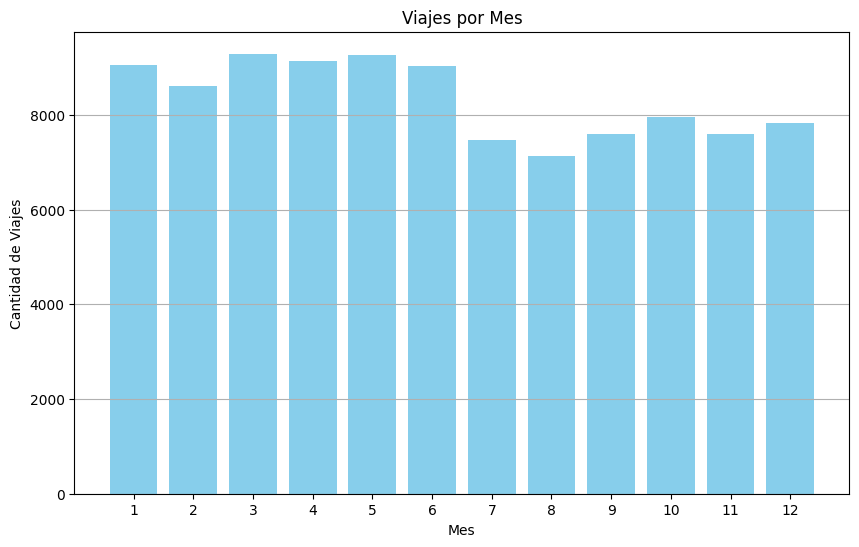

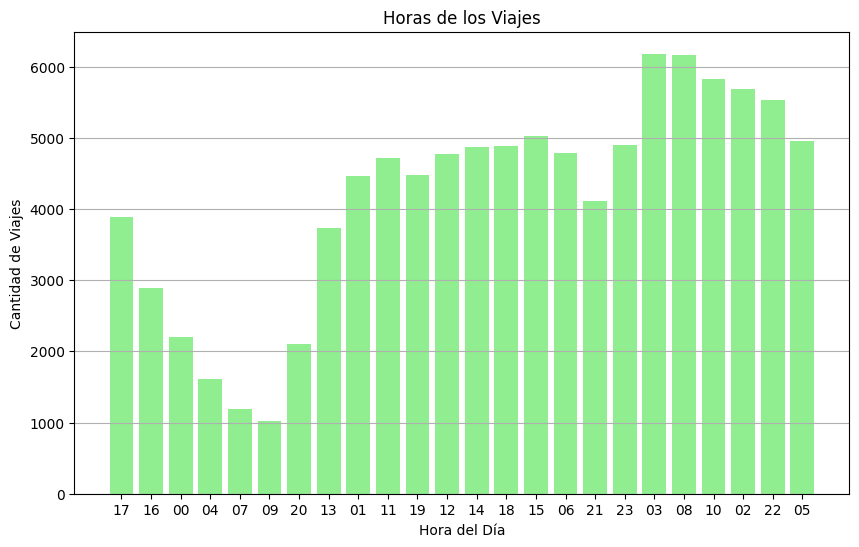

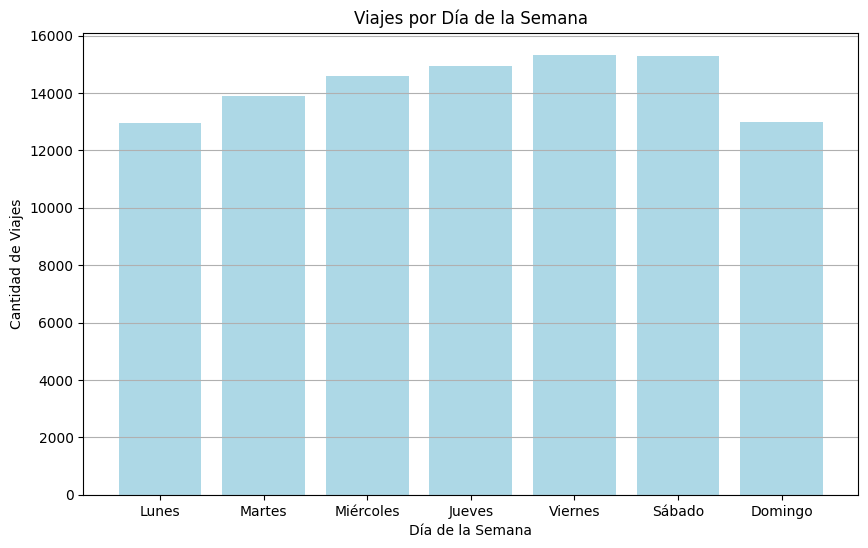

In [39]:
# Convertir la columna 'pickup_datetime' a datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
# Extraer el mes y el año de 'pickup_datetime'
data['month'] = data['pickup_datetime'].dt.month
data['year'] = data['pickup_datetime'].dt.year
data['day']= data['pickup_datetime'].dt.dayofweek

# Extraer la hora de 'pickup_datetime' y asignarla a una nueva columna 'hora'
data['hora'] = data['pickup_datetime'].dt.strftime("%H")
# Contar los viajes por mes
viajes_por_mes = data.groupby(['month']).size()
# Gráfico de viajes por mes
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_mes.index, viajes_por_mes.values, color='skyblue')
plt.title('Viajes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Viajes')
plt.xticks(range(1, 13))
plt.grid(axis='y')
plt.show()

# Gráfico de horas de los viajes
plt.figure(figsize=(10, 6))
plt.bar(data['hora'].unique(), data.groupby('hora').size(), color='lightgreen')
plt.title('Horas de los Viajes')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Viajes')
plt.grid(axis='y')
plt.show()
# Contar los viajes por día de la semana
viajes_por_dia_semana = data.groupby(['day']).size()
# Gráfico de viajes por día de la semana
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_dia_semana.index, viajes_por_dia_semana.values, color='lightblue')
plt.title('Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Viajes')
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.grid(axis='y')
plt.show()

A partir de los datos recopilados, generamos gráficos para analizar la frecuencia de los viajes realizados cada mes y las horas pico de estos viajes. Observamos que las horas con mayor actividad son las 8 y 10 de la mañana, coincidiendo con las horas habituales de inicio de la jornada laboral, según los datos de la ciudad.

En cuanto a los meses, notamos que la primavera y el verano son las estaciones con mayor número de viajes. Esto puede estar relacionado con el aumento del turismo en la ciudad durante estos meses y con las vacaciones estudiantiles.

También, podemos analizar que los dias que más se ocupan taxi son los días viernes y sábados, que es cuando la gente tiende a salir más .

Es importante mencionar que, para este análisis, limitamos la duración de los viajes a un máximo de 3 horas. Esta restricción se basa en la estimación de que un viaje en taxi, considerando diversos factores, no debería exceder este tiempo y nos ayuda a borrar datos de latitud y longitud fuera de lo común presentes en la tabla.

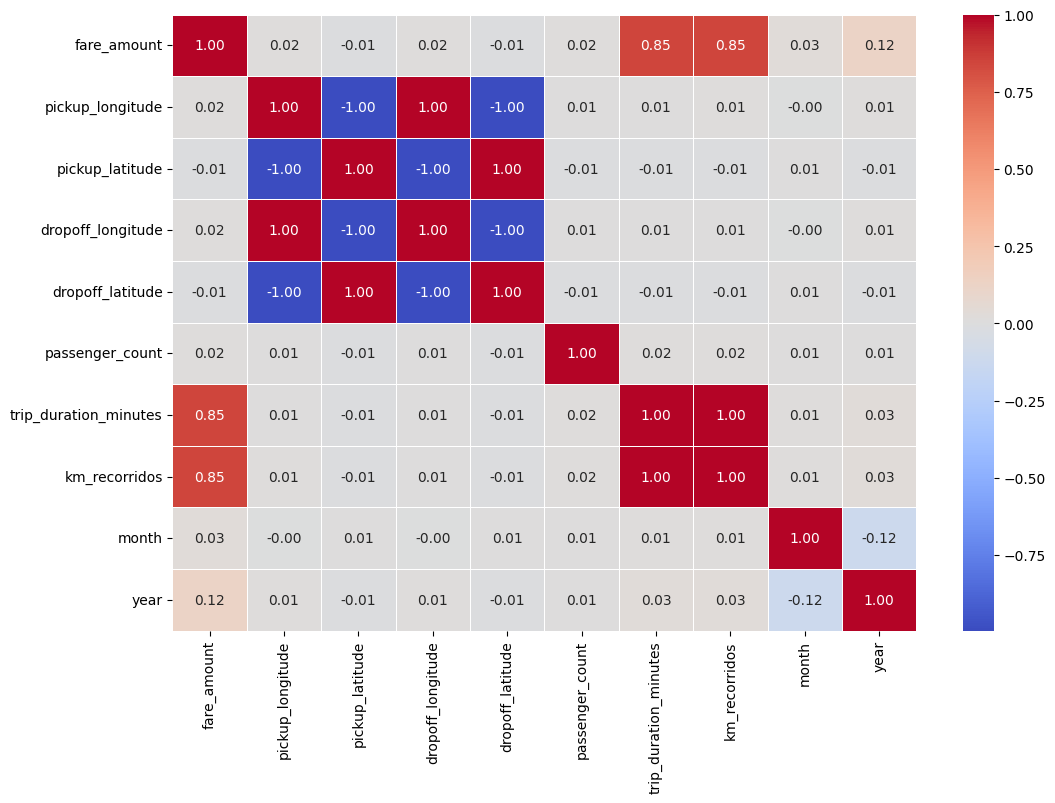

In [25]:
numeric_df = data.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

Tras analizar la matriz de correlación y el mapa de calor, se observa que las variables con mayor correlación con el ‘fare amount’ son aquellas que representan los kilómetros recorridos y el tiempo de viaje en minutos. Esto nos lleva a concluir que estas variables son las que más influyen en el ‘fare amount’.

In [29]:
X = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count','km_recorridos','trip_duration_minutes']]
y = data['fare_amount']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Predecir los valores de la tarifa para los datos de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)


MSE: 23.78643554745088
MAE: 2.438082041246403
R2: 0.7417274720993494


Finalmente, al analizar los resultados de nuestra regresión lineal, observamos que el error absoluto medio es un valor aceptable. Esto indica que la diferencia promedio entre las tarifas reales y las predichas por nuestro modelo será de aproximadamente $2.43. Este valor razonable sugiere que nuestro modelo tiene un buen rendimiento en la estimación de las tarifas.